# Import Libraries

In [1]:
import os
import cv2
import keras
import numpy as np
import seaborn as sns
from PIL import Image 
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Remove Background

In [2]:

img_dir="dataset"

for root,_,files in os.walk(img_dir):
    for file in files:
        if file.endswith(".JPG"):
    
            img_path=os.path.join(root,file)   #join image path with dataset directory
            
            img=cv2.imread(img_path)
            mask = np.zeros(img.shape[:2], np.uint8)
            rect = (25, 25, img.shape[1] - 50, img.shape[0] - 50)
            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)
            cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
            result = img * mask2[:, :, np.newaxis]
            cv2.imwrite(img_path,result)
            
print("Process Completed")

Process Completed


# Split Dataset(80 & 20)

In [3]:
train_datagen = ImageDataGenerator(validation_split=0.2)

test_datagen = ImageDataGenerator(validation_split=0.2)


train_generator = train_datagen.flow_from_directory("C:/Users/sujat/Desktop/cnn/dataset",
                                                    subset="training",
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=8,
                                                    shuffle=False )

test_generator = test_datagen.flow_from_directory("C:/Users/sujat/Desktop/cnn/dataset",
                                                subset="validation",
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=8,
                                                    shuffle=False  )
classes = list(train_generator.class_indices.keys())

Found 7382 images belonging to 5 classes.
Found 1844 images belonging to 5 classes.


# Create Model

In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes),activation='softmax'))

In [5]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

# Fit the model

In [6]:
history=model.fit(train_generator, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
923/923 [==============================] - 626s 672ms/step - loss: 1.6290 - accuracy: 0.3289
Epoch 2/10
923/923 [==============================] - 531s 575ms/step - loss: 1.4207 - accuracy: 0.3855
Epoch 3/10
923/923 [==============================] - 533s 577ms/step - loss: 1.2832 - accuracy: 0.4649
Epoch 4/10
923/923 [==============================] - 529s 573ms/step - loss: 1.0150 - accuracy: 0.5894
Epoch 5/10
923/923 [==============================] - 535s 580ms/step - loss: 0.8903 - accuracy: 0.6361
Epoch 6/10
923/923 [==============================] - 531s 576ms/step - loss: 0.7753 - accuracy: 0.6861
Epoch 7/10
923/923 [==============================] - 547s 592ms/step - loss: 0.6904 - accuracy: 0.7285
Epoch 8/10
923/923 [==============================] - 529s 573ms/step - loss: 0.6404 - accuracy: 0.7390
Epoch 9/10
923/923 [==============================] - 528s 572ms/step - loss: 0.5623 - accuracy: 0.7808
Epoch 10/10
923/923 [==============================] - 531s 575m

In [7]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2)
print(test_acc)

231/231 - 78s - loss: 0.6231 - accuracy: 0.7451 - 78s/epoch - 338ms/step
0.7451193332672119


In [8]:
train_loss,train_acc=model.evaluate(train_generator,verbose=2)
print(train_acc)

923/923 - 141s - loss: 0.3947 - accuracy: 0.8555 - 141s/epoch - 152ms/step
0.8554592132568359


# Accuracy curve

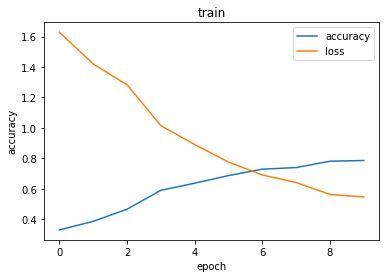

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'])
plt.show()

# Confusion Matrix

231/231 [==============================] - 36s 155ms/step


<Axes: >

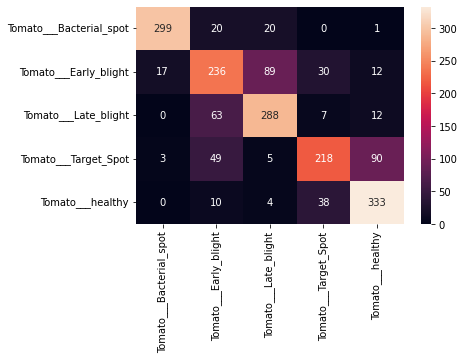

In [10]:
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=classes, yticklabels=classes)

# Classification report(F1 score)

In [11]:
from sklearn.metrics import classification_report
cr= classification_report(true_labels, predicted_labels, target_names=classes)
print(cr)

                         precision    recall  f1-score   support

Tomato___Bacterial_spot       0.94      0.88      0.91       340
  Tomato___Early_blight       0.62      0.61      0.62       384
   Tomato___Late_blight       0.71      0.78      0.74       370
   Tomato___Target_Spot       0.74      0.60      0.66       365
       Tomato___healthy       0.74      0.86      0.80       385

               accuracy                           0.75      1844
              macro avg       0.75      0.75      0.75      1844
           weighted avg       0.75      0.75      0.74      1844



# Predicting an image

Following is our prediction:
1/1 [==============================] - 0s 34ms/step


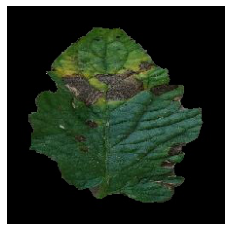

1
Predicted image: Tomato___Early_blight
Accuracy: 85.00436544418335


In [25]:
image_path="C:/Users/sujat/Desktop/cnn/TomatoEarlyBlight4.JPG"

new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

print("Following is our prediction:")
prediction = model.predict(img)

plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.show()

pred=prediction[0].argmax()
print(pred)
print("Predicted image: " + classes[prediction[0].argmax()])
print("Accuracy:",(prediction[0][pred]*100))